<a href="https://colab.research.google.com/github/AleemRahil/Robust-End-to-End-E-Commerce-Analytics-Automation-with-LLMs/blob/main/Intereactive_dashboards_with_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Build Interactive Dashboards with LLMs in Minutes

Extracting insights from customer data can be a time-consuming process, especially for those who lack advanced SQL skills. Many companies struggle to gain a clear understanding of important **acquisition and retention metrics** such as **repeat revenue**, **Customer Lifetime Value (CLV)**, **churn rate**s, or **product bundling opportunities**. Such a knowledge gap can impede business growth.

Fortunately, large language models (**LLMs**) have fundamentally changed how we approach data analysis. By leveraging LLMs, we can extract meaningful information from databases with remarkable efficiency, effectively reducing the time required by a factor of ten. This opens new business possibilities to uncover actionable insights and make informed strategic decisions quickly.

In this project, I will explore how to harness the capabilities of LLMs and LangChain to build **interactive dashboards** that provide a comprehensive view of your business data. I will use **LangChain** chains to **extract insights** from BigQuery and build the dashboards in **Looker Studio**. The process involves **generating SQL queries using LLMs** and then **pushing these queries to BigQuery** as views. While I will use **BigQuery** and Looker Studio as example platforms, the concepts and techniques covered in this tutorial can be easily extended to other data warehouses and dashboard tools.

In this project, I have implemented the followed:

*   Set up the necessary environment and dependencies
*   Fetch BigQuery schemas to understand the structure of your data
*   Connect to BigQuery using the appropriate credentials
*   Configure and utilize LLMs, such as Claude-3, to generate SQL queries
*   Create BigQuery views based on the generated SQL queries
*   Load and process insights from a file to automate view creation
*   Generate meaningful view names using LLMs
*   Handle query execution failures and retries


#Setting up the Environment

In [ ]:
!pip install -qU \
  python-dotenv \
  langchain \
  anthropic \
  langchain-anthropic \
  google-cloud-bigquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.7/870.7 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 11.6 MB/s eta 0:00:00


#Fetching BigQuery Schemas

Before we can generate SQL queries, we need to fetch the schemas of the tables in our BigQuery dataset.
The fetch_schemas function retrieves the schema descriptions for all tables in a given dataset.

In [ ]:
def build_schema_desc(fields, prefix=""):
    """Build schema description, including nested fields."""
    desc = []
    for f in fields:
        d = f"{prefix}- Name: {f.name}, Type: {f.field_type}, Mode: {f.mode}"
        desc.append(d)
        if f.field_type == 'RECORD':
            sub_desc = build_schema_desc(f.fields, prefix + "    ")
            desc.extend(sub_desc)
    return desc


def fetch_schemas(dataset_id, client):
    """Fetch schema descriptions for all tables in a dataset."""
    schemas = []
    simple_table_list = []

    tables = client.list_tables(dataset_id)
    for table in tables:
        ref = client.get_table(table)

        simple_table_list.append(f"- {ref.project}.{ref.dataset_id}.{ref.table_id}")

        schema_desc = [f"Schema for {table.table_id}:"]
        schema_desc += build_schema_desc(ref.schema)
        schema_desc.append("")  # For newline

        schemas += schema_desc

    return "\n".join(simple_table_list) + "\n\n" + "\n".join(schemas)

The function builds a schema description by iterating over the fields of each table and appending the field name, type, and mode to the description. It also handles nested fields by recursively calling itself with the appropriate prefix.

In [ ]:
#print(fetch_schemas(full_dataset_id,gbq_client))

#Connecting to BigQuery

To interact with BigQuery, we must set up the necessary credentials and create a client object. We load the service account key from a JSON file and initialize the bigquery.Client with the credentials.

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account

service_account_path = './yourkey.json'

project="your_project"
dataset="your_dataset"
full_dataset_id = f"{project}.{dataset}"

url = f'bigquery://{project}/{dataset}?credentials_path={service_account_path}'

credentials = service_account.Credentials.from_service_account_file(service_account_path)
gbq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)

#Setting up the LLM

For this tutorial, we will be using the Claude-3 model from Anthropic. We load the environment variables from a .env file and create an instance of ChatAnthropic with the desired model.

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

from langchain_anthropic import ChatAnthropic
llm_claude3 = ChatAnthropic(model='claude-3-opus-20240229')

## Setup SQL Chain

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [ ]:
template = """Based on the BigQuery schema below, write a SQL query
(only return clean SQL no quotes or text)  that answers the question/request.
Write main query ALIAS in short simple capital letters.
Remember to UNNEST repeated records and CAST timestamps/dates in the right format when comparing or subtracting:
schema:{schema}
Question: {question}
SQL Query:"""
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
def get_schema(_):
    return fetch_schemas(full_dataset_id,gbq_client)


sql_chain = (
    RunnablePassthrough.assign(schema=get_schema)
    | prompt
    | llm_claude3.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)

#Generating SQL Queries

In [ ]:
#Test the SQL Chain
res=sql_chain.invoke({"question": 'New vs Repeat Revenue over time in the last 30 days'})
print(res)
gbq_client.query(res).to_dataframe()

WITH ORDERS AS (
  SELECT
    o.id AS order_id,
    o.createdAt AS order_created_at,
    o.currencyCode AS currency_code,
    o.customer.id AS customer_id,
    o.lineItems,
    MIN(o.createdAt) OVER (PARTITION BY o.customer.id) AS first_order_date
  FROM rabbitpromotion.ecomdata_looker.orders o
  WHERE o.createdAt >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
),

ORDER_ITEMS AS (
  SELECT
    order_id,
    order_created_at,
    currency_code,
    customer_id,
    first_order_date,
    SUM(lineItem.price) AS order_value
  FROM ORDERS o, UNNEST(o.lineItems) lineItem
  GROUP BY 1, 2, 3, 4, 5
)

SELECT
  DATE(order_created_at) AS order_date,
  SUM(CASE WHEN order_created_at = first_order_date THEN order_value ELSE 0 END) AS new_revenue,
  SUM(CASE WHEN order_created_at > first_order_date THEN order_value ELSE 0 END) AS repeat_revenue
FROM ORDER_ITEMS
GROUP BY 1
ORDER BY 1


,order_date,new_revenue,repeat_revenue
0,2024-03-22,1990.95,0.00
1,2024-03-23,13830.13,0.00
2,2024-03-24,13480.42,0.00
3,2024-03-25,11852.86,0.00
4,2024-03-26,15579.42,0.00
5,2024-03-27,19304.81,0.00
6,2024-03-28,12544.98,221.69
7,2024-03-29,9179.01,0.00
8,2024-03-30,10459.50,0.00
9,2024-03-31,13377.17,0.00


In [ ]:
create_bigquery_view('looker_studio_views', 'new_vs_repeat_revenue', gbq_client, res)

WITH ORDERS AS (
  SELECT
    o.id AS order_id,
    o.createdAt AS order_created_at,
    o.currencyCode AS currency_code,
    o.customer.id AS customer_id,
    o.lineItems,
    MIN(o.createdAt) OVER (PARTITION BY o.customer.id) AS first_order_date
  FROM rabbitpromotion.ecomdata_looker.orders o
  WHERE o.createdAt >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
),

ORDER_ITEMS AS (
  SELECT
    order_id,
    order_created_at,
    currency_code,
    customer_id,
    first_order_date,
    SUM(lineItem.price) AS order_value
  FROM ORDERS o, UNNEST(o.lineItems) lineItem
  GROUP BY 1, 2, 3, 4, 5
)

SELECT
  DATE(order_created_at) AS order_date,
  SUM(CASE WHEN order_created_at = first_order_date THEN order_value ELSE 0 END) AS new_revenue,
  SUM(CASE WHEN order_created_at > first_order_date THEN order_value ELSE 0 END) AS repeat_revenue
FROM ORDER_ITEMS
GROUP BY 1
ORDER BY 1
    order_date  new_revenue  repeat_revenue
0   2024-03-22      1990.95            0.00
1   2024-03-23     138

#Loading Insights from a File

In [ ]:
# Load insights from text file
def load_insights(file_path):
    with open(file_path, 'r') as file:
        insights = [line.strip() for line in file.readlines()]
    return insights

In [ ]:
insights = load_insights('insight_wishlist.txt')

In [ ]:
insights

['New customers in the last 30 days',
 'New orders in the last 30 days',
 'Total revenue in the last 30 days',
 'Repeat revenue in the last 30 days',
 'AOV overall',
 'Repeat order rate overall',
 'New vs Repeat Revenue over time in the last 30 days',
 'Top 10 product pairs most frequently bought together',
 'Revenue by acquisition channel by gender in the last 30 days for a bar chart',
 'Revenue by city for the top 25 cities ranked by revenue']

## Generate View Descriptions

In [ ]:
system_prompt="""
You write short names for views based on input and return list of strings that can be processed in Python
"""

In [ ]:
view_description_prompt=f"""
Write a short name for a bigquery view for each insight description. Only return names in a python list
no other text. Use underscore if necessary:

List of insights:    {insights}
"""

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=view_description_prompt),
]

In [ ]:
descriptions=llm_claude3.invoke(messages)

In [ ]:
import ast

view_names=ast.literal_eval(descriptions.content)

In [ ]:
view_names

['new_customers_last_30_days',
 'new_orders_last_30_days',
 'total_revenue_last_30_days',
 'repeat_revenue_last_30_days',
 'aov_overall',
 'repeat_order_rate_overall',
 'new_vs_repeat_revenue_over_time_last_30_days',
 'top_10_product_pairs_frequently_bought_together',
 'revenue_by_acquisition_channel_by_gender_last_30_days_bar_chart',
 'revenue_by_city_top_25_cities_by_revenue']

## Create Views

Finally, we process the insights and create BigQuery views using the process_insights function. This function iterates over the insights and view names, generates SQL queries using the SQL chain, and creates views in BigQuery.

In [ ]:
# Function to create a BigQuery view
def create_bigquery_view(dataset_id, view_name, gbq_client, query):
    # Create a full view ID with the dataset and project ID
    print(query)
    print(gbq_client.query(query).to_dataframe())
    full_view_id = f"{gbq_client.project}.{dataset_id}.{view_name}"
    view = bigquery.Table(full_view_id)
    view.view_query = query
    view = gbq_client.create_table(view)  # API request to create the view
    print(f"Created {view.table_type} '{view.table_id}' successfully.")

# Main function to process insights and create views
def process_insights(dataset_name, insights, view_names, sql_chain, gbq_client):
    for insight, view_name in zip(insights, view_names):
        attempt_count = 0
        success = False
        while not success and attempt_count < 3:  # Retry up to 3 times
            try:
                # Generate SQL query from insight
                sql_query = sql_chain.invoke({"question": insight})

                # Execute the query to test if it works before creating a view
                query_job = gbq_client.query(sql_query)
                query_job.result()  # Wait for the query to complete

                # If successful, create the view
                create_bigquery_view(dataset_name, view_name, gbq_client, sql_query)
                success = True
            except Exception as e:
                print(f"Failed to execute query for '{insight}': {e}")
                attempt_count += 1
                if attempt_count == 3:
                    print(f"Max retries reached for '{insight}'. Moving to the next one.")




In [ ]:
insights = load_insights('insight_wishlist.txt')
insights

['New customers in the last 30 days',
 'New orders in the last 30 days',
 'Total revenue in the last 30 days',
 'Repeat revenue in the last 30 days',
 'AOV overall',
 'Repeat order rate overall',
 'New vs Repeat Revenue over time in the last 30 days',
 'Top 10 product pairs most frequently bought together',
 'Revenue by acquisition channel by gender in the last 30 days for a bar chart',
 'Revenue by city for the top 25 cities ranked by revenue']

In [ ]:
view_names

['new_customers_last_30_days',
 'new_orders_last_30_days',
 'total_revenue_last_30_days',
 'repeat_revenue_last_30_days',
 'aov_overall',
 'repeat_order_rate_overall',
 'new_vs_repeat_revenue_over_time_last_30_days',
 'top_10_product_pairs_frequently_bought_together',
 'revenue_by_acquisition_channel_by_gender_last_30_days_bar_chart',
 'revenue_by_city_top_25_cities_by_revenue']

In [ ]:
dataset_name = 'looker_studio_views'
process_insights(dataset_name, insights, view_names,sql_chain, gbq_client)

SELECT COUNT(DISTINCT c.id) AS NEW_CUSTOMERS_30D
FROM rabbitpromotion.ecomdata_looker.customers c
WHERE c.createdAt >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
   NEW_CUSTOMERS_30D
0                742
Created VIEW 'new_customers_last_30_days' successfully.
SELECT
  COUNT(*) AS NEW_ORDERS_LAST_30_DAYS
FROM
  `rabbitpromotion.ecomdata_looker.orders`
WHERE
  CAST(createdAt AS DATE) >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
   NEW_ORDERS_LAST_30_DAYS
0                      872
Created VIEW 'new_orders_last_30_days' successfully.
SELECT
  SUM(li.price) AS REVENUE_LAST_30D
FROM
  `rabbitpromotion.ecomdata_looker.orders` o
CROSS JOIN
  UNNEST(o.lineItems) AS li
WHERE
  o.createdAt >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
   REVENUE_LAST_30D
0         379973.16
Created VIEW 'total_revenue_last_30_days' successfully.
SELECT
  SUM(LI.price) AS REPEAT_REVENUE_LAST_30D
FROM
  `rabbitpromotion.ecomdata_looker.orders` O
  CROSS JOIN UNNEST(lineItems) AS LI
WHERE
  O.crea

#Setting Up The Dashboard


Step 1: Initiate a New Looker Studio Report
*   Navigate to Looker Studio.
*   Start a new report by selecting the + New Report option.

Step 2: Connect to BigQuery
*   Within your new report, click on Add Data.
*   From the list of data sources, select BigQuery.

Step 3: Choose Your BigQuery Project and Dataset

*   Find your BigQuery project in the list and expand it.
*   Select the dataset that contains the view you want to use.

Step 4: Integrate BigQuery Views
*   After connecting, you will see a list of fields from your BigQuery view.
*   Add the desired fields to your report.

Step 5: Layout Your Dashboard

*   Drag and drop the selected fields onto the report canvas to create visualizations.
*   Pick chart types and adjust their settings to fit the data representation you need.

Step 6: Apply Styling
*   Use Theme and Layout tools to style your dashboard.
*   Arrange your elements neatly for clarity.

Step 7: Implement Interactive Controls
*   From the toolbar, add interactive controls like date range selectors or filters.
*   Link these controls to your data elements for dynamic interactivity.



Step 8: Finalize and Share

*   Use the View mode to preview your dashboard's functionality.

*   Share the finished dashboard by clicking on Share, and set the viewing or
editing permissions as needed.

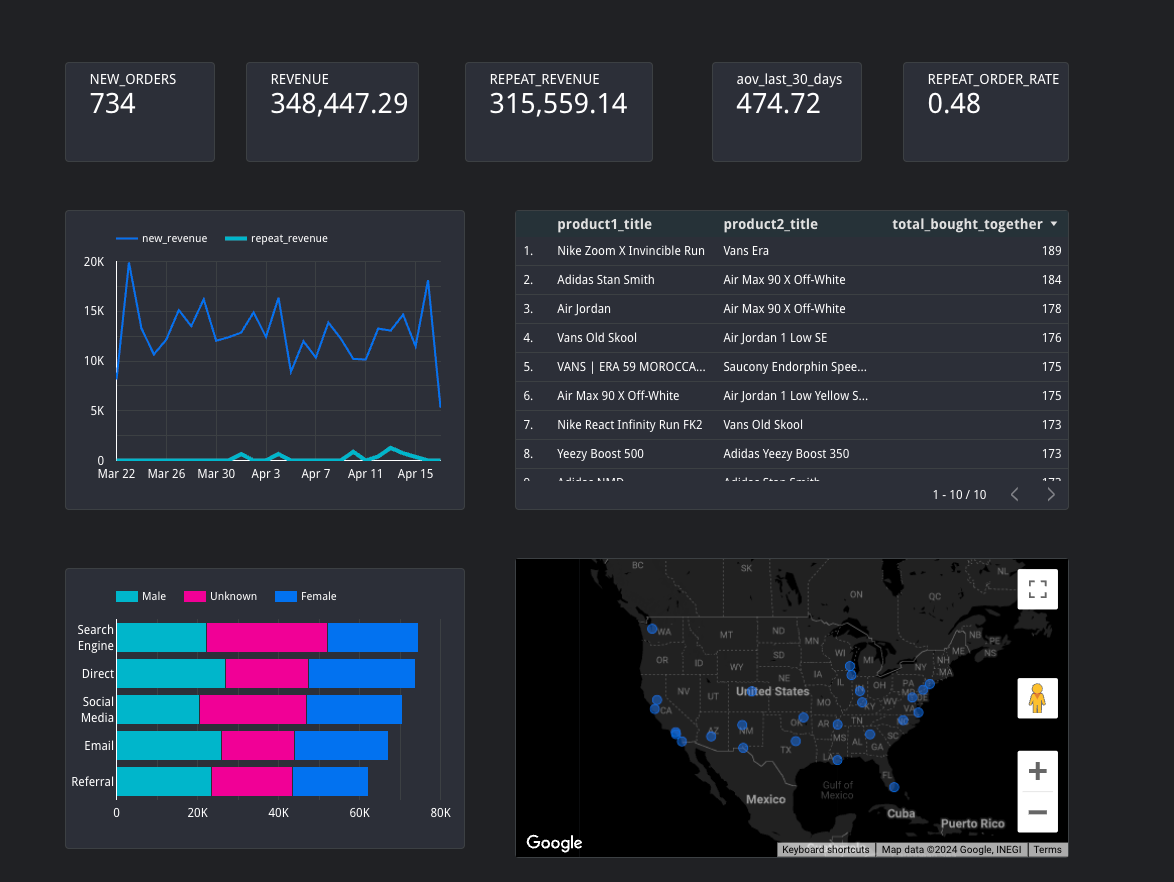